# 1. Import das bibliotecas e limpeza de dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

plt.style.use('seaborn')
%matplotlib inline

In [2]:
# 'sales' é o dataset da empresa B e 'comp' é o dataset da competição, constituída das 
# empresas C1, ..., C6.
sales = pd.read_csv("sales.csv")
comp = pd.read_csv("comp_prices.csv")

In [3]:
sales.head()

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-08-02,1.0,1808.99
1,P6,2015-08-17,1.0,1674.00
2,P6,2015-08-17,1.0,1673.95
3,P6,2015-08-11,1.0,1674.00
4,P6,2015-08-17,1.0,1674.00


In [4]:
comp.head()

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE
0,P6,2015-01-30 08:11:38,C3,1898.00,1
1,P6,2015-01-30 08:11:38,C1,1898.00,1
2,P6,2015-01-30 08:11:38,C6,1999.90,1
3,P6,2015-01-31 20:10:14,C2,1894.88,2
4,P6,2015-01-31 20:10:14,C3,1894.88,2


## 1.1. Dados omissos e remoção de ouliers

Abaixo, podemos notar que não há dados faltando em ambos os datasets.

In [5]:
for column in sales.columns:
    print(sales[column].value_counts(dropna=True).sort_values())
    print()

P3      2899
P1      4091
P6      4102
P4     14656
P9     18431
P5     19775
P8     27840
P2     63358
P7    195939
Name: PROD_ID, dtype: int64

2015-03-14      131
2015-08-02      188
2015-03-15      193
2015-01-11      194
2015-01-17      218
2015-01-12      248
2015-03-22      255
2015-08-16      259
2015-08-29      261
2015-01-08      263
2015-01-18      263
2015-08-30      272
2015-08-23      275
2015-08-15      290
2015-08-28      292
2015-08-22      299
2015-01-10      306
2015-06-28      307
2015-03-23      308
2015-08-13      320
2015-05-18      322
2015-01-01      337
2015-02-01      342
2015-06-06      342
2015-03-28      343
2015-03-29      347
2015-06-07      350
2015-08-14      352
2015-08-12      381
2015-01-13      386
              ...  
2015-02-11     2407
2015-08-31     2410
2015-05-09     2467
2015-06-18     2471
2015-09-20     2509
2015-04-30     2514
2015-06-30     2516
2015-05-04     2531
2015-06-24     2686
2015-05-02     2711
2015-09-30     2794
2015-03-03    

In [6]:
for column in comp.columns:
    print(comp[column].value_counts(dropna=True).sort_values())
    print()

P4    1689
P5    1896
P1    2713
P8    5795
P3    5853
P9    6123
P7    7748
P2    8755
P6    9542
Name: PROD_ID, dtype: int64

2015-01-12 08:10:21      6
2015-01-06 20:10:05      6
2015-01-11 20:10:05      6
2015-01-25 08:10:22     10
2015-01-27 08:10:26     10
2015-01-07 08:10:21     10
2015-01-02 20:10:04     10
2015-01-12 20:10:05     10
2015-02-02 08:10:22     10
2015-01-15 08:10:27     10
2015-01-14 20:10:05     10
2015-01-10 08:10:24     10
2015-01-29 20:10:23     10
2015-01-28 20:10:05     10
2015-01-31 20:10:05     10
2015-02-03 08:10:22     10
2015-01-02 08:10:22     10
2015-01-26 08:10:20     10
2015-01-13 20:10:05     10
2015-01-26 20:10:06     10
2015-02-01 08:10:21     10
2015-01-01 08:10:25     10
2015-02-01 20:10:05     10
2015-02-05 20:10:22     10
2015-01-31 08:10:22     10
2015-01-06 08:10:24     10
2015-01-30 20:10:05     10
2015-01-16 08:10:22     10
2015-01-07 20:10:05     10
2015-01-01 20:10:05     10
                      ... 
2015-08-04 20:10:22     78
2015-06-

Para se ter uma noção melhor dos outliers de algumas colunas escolhidas, usaremos a visualização por boxplot. Estamos fazendo o plot dos dados em escala logarítmica uma vez que há valores muito grandes entre os dados.

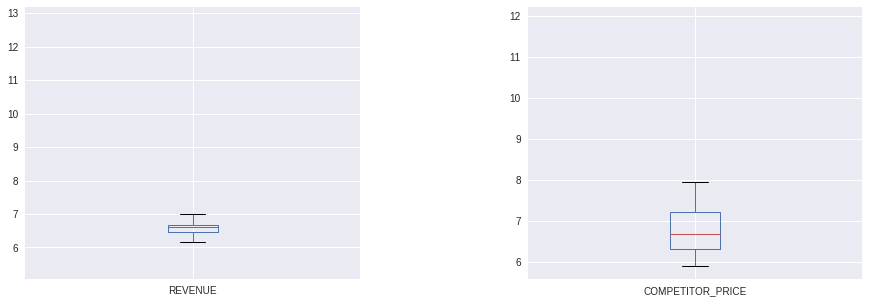

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
np.log(sales['REVENUE']).plot.box(ax=ax[0])
np.log(comp['COMPETITOR_PRICE']).plot.box(ax=ax[1])
fig.subplots_adjust(wspace=0.5)

Baseado nestes gráficos, propomos retirar os outliers como mostrado abaixo. A porcentagem dos dados retidos é ainda grande o suficiente para considerarmos plausível a remoção dos outliers. Consideramos retirar no máximo até $1\%$ dos dados, de modo a não perder informação demais.

In [8]:
# Vamos selecionar pedaços onde se encontram a maior parte dos elementos segundo as 
# barras acima.
first = sales[np.log(sales['REVENUE']) <= 8]['REVENUE']
second = comp[np.log(comp['COMPETITOR_PRICE']) < 9]['COMPETITOR_PRICE']

# Vamos ver a quantidade de ocorrências destes outliers. Após fazermos mais algumas 
# análises, podemos decidir se eles podem ser removidos ou não do dataset.
print('Porcentagem dos elementos removidos')
print('---------------------------------')
print('REVENUE:', round(100-100*first.shape[0]/sales.shape[0], 2), '%')
print('COMPETITOR_PRICE:', round(100-100*second.shape[0]/comp.shape[0], 2), '%')
print()

# Agora atualizamos as colunas.
sales_updated = sales.copy()
comp_updated = comp.copy()
sales_updated['REVENUE'] = first
comp_updated['COMPETITOR_PRICE'] = second

Porcentagem dos elementos removidos
---------------------------------
REVENUE: 0.51 %
COMPETITOR_PRICE: 0.15 %



Ao criar estes novos datasets introduzimos NaNs. Estas linhas com NaNs são aquelas que consideramos como outliers.

In [9]:
print(sales_updated.isnull().sum())
print()
print(comp_updated.isnull().sum())

PROD_ID          0
DATE_ORDER       0
QTY_ORDER        0
REVENUE       1777
dtype: int64

PROD_ID              0
DATE_EXTRACTION      0
COMPETITOR           0
COMPETITOR_PRICE    76
PAY_TYPE             0
dtype: int64


In [10]:
# Removemos as linhas com pelo menos um NaN.
sales_updated = sales_updated.dropna()
comp_updated = comp_updated.dropna()
print(sales_updated.isnull().sum())
print()
print(comp_updated.isnull().sum())

PROD_ID       0
DATE_ORDER    0
QTY_ORDER     0
REVENUE       0
dtype: int64

PROD_ID             0
DATE_EXTRACTION     0
COMPETITOR          0
COMPETITOR_PRICE    0
PAY_TYPE            0
dtype: int64


## 1.2. Ajuste das colunas

Podemos ver acima que todas as datas se encontram no mesmo ano, 2015, então podemos omitir o ano e considerá-lo uma informação implícita do dataset. Além disso, consideramos desnecessário o horário da extração dos preços da competição. 

Algumas colunas se referem ao mesmo tipo de informação, então iremos renomeá-las como indicado abaixo:

sales column name | comp column name | new name
-----|----|-----|
DATE_ORDER | DATE_EXTRACTION| DATE
REVENUE | COMPETITOR_PRICE | REVENUE
PROD_ID | PROD_ID | PROD

In [11]:
# Vamos padronizar o formato das datas, que será mês/dia, pois o ano é sempre 2015 
# e o horário não parece ser muito relevante.
sales_updated['DATE_ORDER'] = sales_updated['DATE_ORDER'].str.replace('2015-', '')
comp_updated['DATE_EXTRACTION'] = comp_updated['DATE_EXTRACTION'].str.replace('2015-', '').str.split(' ').str[0]

In [12]:
# Padronizamos os nomes das colunas.
sales_updated = sales_updated.rename(columns={'DATE_ORDER': 'DATE', 'PROD_ID': 'PROD'})
comp_updated = comp_updated.rename(columns={'DATE_EXTRACTION': 'DATE', 'COMPETITOR_PRICE': 'REVENUE', 'PROD_ID': 'PROD'})

Uma coisa que foi mostrada acima é o fato de que os dois tipos de pagamento (coluna 'PAY_TYPE') ocorrem exatamente o mesmo número de vezes. Podemos nos perguntar se essa coincidência vale mais em geral. Mais precisamente, podemos nos perguntar se a cada produto o tipo de compra é dividido também igualmente e se a cada competidor o tipo de compra é dividido igualmente. Porque se essa divisão for sempre meio a meio, então 'PAY_TYPE' acaba não sendo um atributo muito informativo e pode ser descartado. Vamos averiguar isso agora.

In [13]:
comp_competitor = comp_updated.groupby('COMPETITOR')
comp_prod = comp_updated.groupby('PROD')

In [14]:
competitors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
products = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']

for c in competitors:
    print('Competitor ' + c + ':')
    print(comp_competitor.get_group(c)['PAY_TYPE'].value_counts())
    print()

print('-------------------------------------')
for p in products:
    print('Product ' + p + ':')
    print(comp_prod.get_group(p)['PAY_TYPE'].value_counts())
    print()

Competitor C1:
1    4929
2    4923
Name: PAY_TYPE, dtype: int64

Competitor C2:
1    4880
2    4874
Name: PAY_TYPE, dtype: int64

Competitor C3:
1    4842
2    4837
Name: PAY_TYPE, dtype: int64

Competitor C4:
1    3992
2    3987
Name: PAY_TYPE, dtype: int64

Competitor C5:
1    2142
2    2139
Name: PAY_TYPE, dtype: int64

Competitor C6:
1    4249
2    4244
Name: PAY_TYPE, dtype: int64

-------------------------------------
Product P1:
1    1354
2    1351
Name: PAY_TYPE, dtype: int64

Product P2:
1    4374
2    4371
Name: PAY_TYPE, dtype: int64

Product P3:
1    2925
2    2918
Name: PAY_TYPE, dtype: int64

Product P4:
1    843
2    842
Name: PAY_TYPE, dtype: int64

Product P5:
2    945
1    945
Name: PAY_TYPE, dtype: int64

Product P6:
2    4766
1    4766
Name: PAY_TYPE, dtype: int64

Product P7:
1    3872
2    3866
Name: PAY_TYPE, dtype: int64

Product P8:
1    2896
2    2891
Name: PAY_TYPE, dtype: int64

Product P9:
1    3059
2    3054
Name: PAY_TYPE, dtype: int64



Podemos observar que os tipos de pagamentos se distribuem de maneira muito bem dividida, sendo praticamente meio a meio sempre. Por conta disso iremos descartar esta coluna.

In [15]:
# Removemos a coluna 'PAY_TYPE'.
comp_updated = comp_updated.drop('PAY_TYPE', axis=1)

Vamos dar uma olhada nos datasets que iremos usar para fazer as predições.

In [16]:
sales_updated.head()

,PROD,DATE,QTY_ORDER,REVENUE
0,P6,08-02,1.0,1808.99
1,P6,08-17,1.0,1674.00
2,P6,08-17,1.0,1673.95
3,P6,08-11,1.0,1674.00
4,P6,08-17,1.0,1674.00


In [17]:
comp_updated.head()

,PROD,DATE,COMPETITOR,REVENUE
0,P6,01-30,C3,1898.00
1,P6,01-30,C1,1898.00
2,P6,01-30,C6,1999.90
3,P6,01-31,C2,1894.88
4,P6,01-31,C3,1894.88


Logo no início do dataset 'sales_updated' podemos perceber que há um mesmo produto sendo vendido três vezes no mesmo dia, talvez até mais, mas vamos supor que seja três. O produto em questão é o P6, na data 2015-08-17. Como o nosso interesse é prever a quantidade de vendas por produto em cada momento, o correto seria que este produto aparecesse apenas uma vez, com o valor da coluna 'QTY_ORDER' sendo igual a 3. Antes de continuar devemos arrumar isso para todas as possíveis ocorrências. 

In [18]:
# Fazemos um loop nos rendimentos para data e produto fixados. A ideia é verificar se há 
# repetições.  No caso positivo, somamos as repetições, guardamos a linha com a quantidade 
# atualizada e removemos as linhas antigas do dataframe.
def fix_qty_order(df):
    """
    Arruma as quantidades em relação a um dado produto e dia.    
    Warning: esta função é lenta.
    
    Parameters
    ----------
    df: dataframe
    
    Return
    ------
    df: dataframe
        Dataframe após a organização das quantidades (coluna 'QTY_ORDER').
    """

    for date in df['DATE'].unique():
        for p in df['PROD'].unique():
            new_rows = []
            # Fazemos os agrupamentos necessários.
            df_group1 = df.groupby('PROD')
            df_group_p = df_group1.get_group(p)
            df_group2 = df_group_p.groupby('DATE')
            
            try:
                df_group_p_d = df_group2.get_group(date)
                
                for r in df_group_p_d['REVENUE'].unique():
                    sample = df_group_p_d[df_group_p_d['REVENUE']==r]
                    sample_qty = sample.shape[0]
                    if sample_qty > 1:
                        new_rows.append([p, date, sample_qty, r])
                        idx = df[(df['PROD']==p) & (df['DATE']==date) & (df['REVENUE']==r)].index
                        df = df.drop(idx)

                new_rows = pd.DataFrame(new_rows, columns=['PROD', 'DATE', 'QTY_ORDER', 'REVENUE'])
                df = pd.concat([df, new_rows], ignore_index=True, sort=False)
            
            except KeyError:
                pass
            
    return df


sales_updated = fix_qty_order(sales_updated)
sales_updated.head()

,PROD,DATE,QTY_ORDER,REVENUE
0,P6,08-02,1.0,1808.99
1,P6,08-06,1.0,1676.99
2,P6,08-23,1.0,1728.90
3,P6,07-27,1.0,1787.41
4,P6,07-28,1.0,1874.32


# 2. Análise de venda dos produtos

Nesta parte, vamos ver quais produtos interessam mais a cada uma das empresas. O "interesse" aqui é medido pela coluna 'REVENUE', que nos diz o rendimento que a empresa obteve em cima do produto. Para isto, nos utilizamos da visualização de gráficos de barras.

In [19]:
# Primeiro começamos juntando os dataframes verticalmente. Para isso, é interessante que o 
# dataframes 'sales' tenha uma coluna para encaixar com a coluna 'COMPETITOR'. Vamos 
# renomear esta coluna para 'SELLER', e no primeiro dataframe esta coluna será preenchida 
# com 'B'.

sales_updated['SELLER'] = 'B'
comp_updated = comp_updated.rename(columns={'COMPETITOR': 'SELLER'})
new_data = pd.concat([sales_updated, comp_updated], ignore_index=True, sort=False)

In [20]:
# Durante a junção dos dataframes, apenas as entradas em 'QTY_ORDER' relativas à competição 
# são NaN.
new_data.isnull().sum()

PROD             0
DATE             0
QTY_ORDER    50038
REVENUE          0
SELLER           0
dtype: int64

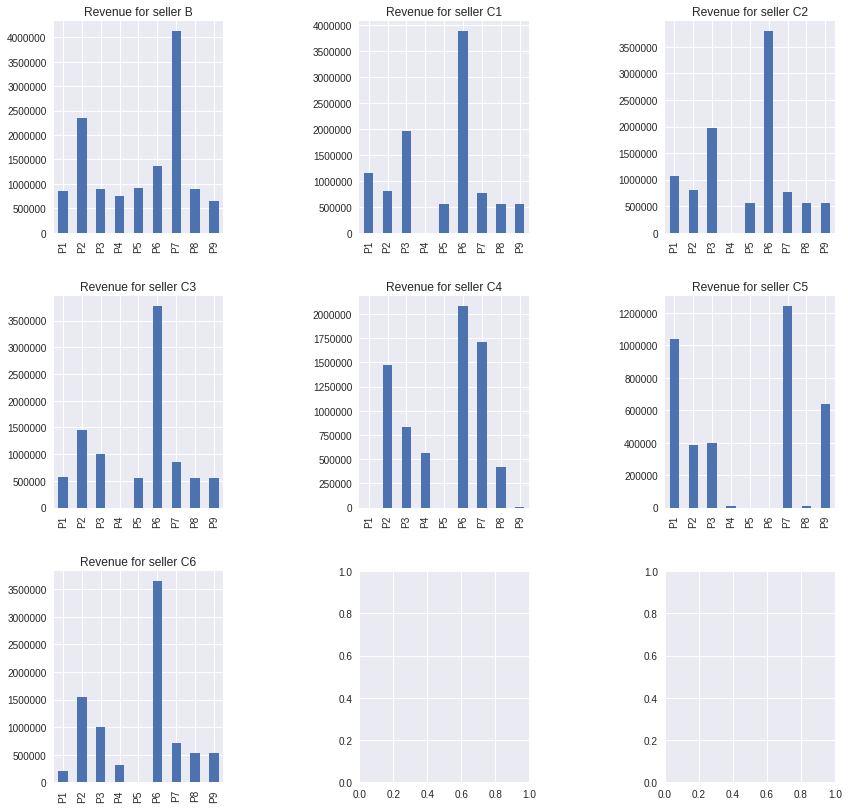

In [21]:
# Cada elemento de total_revenue é um dicionário da forma
# total_revenue[p] = {'B': Rendimento total de B para o produto p, 
#                     'C1': Rendimento total de C1 para o produto p, 
#                      ...,
#                     'C5': Rendimento total de C5 para o produto p }.

def revenue_per_product(seller, product_groups, products):
    """
    Para cada seller, esta função computa uma série temp com 6 elementos, tal que temp[p] é o 
    rendimento total de seller em relação ao produto p. Evitamos levar em conta as quantidade
    pois tratamos as vendas da competição como unidades, uma vez que não temos esta informação.
    """
    
    temp = {}
    for p in products:
        product_tmp = product_groups.get_group(p)
        temp[p] = product_tmp[product_tmp['SELLER']==seller]['REVENUE'].sum()
    temp = pd.Series(temp)
    return temp
    
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
product_groups = new_data.groupby('PROD')
products = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
sellers = ['B', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Plot dos gráficos de barra.
i = 0
j = 0
for seller in sellers:
    temp_series = revenue_per_product(seller, product_groups, products)
    temp_series.plot(kind='bar', title='Revenue for seller '+seller, ax=ax[i][j])
    j += 1
    if j==3:
        j = 0
        i += 1    
fig.subplots_adjust(wspace=0.8, hspace=0.3)   
plt.show()

De maneira geral, os produtos de mais interesse são P6 e P7, com a exceção de P1 que é de bastante interesse para C5. A empresa B tem claro foco no produto P7 e praticamente nenhum interesse em P1 e P6. Pelo que podemos ver dos histogramas, todos os competidores, exceto C5, seguem a estratégia de vender mais o produto P6. O competidor C5 parece tentar vender mais P7, o produto mais vendido por B, e P1, um dos produtos menos vendidos por B. Note que o competidor C4 também vende bastante do P7. Podemos ver dois tipos de estratégias aqui:

 **1)** Se concentrar em um único produto em que B possui poucos consumidores.
 
 **2)** Se concentrar em dois produtos, um em que B possui poucos consumidores e outro em que B possui muitos consumidores.

## 2.1. Séries temporais

Vimos os produtos que interessam mais a cada empresa, e a partir disso traçamos uma ideia geral da estratégia escolhida por cada empresa. Pelos valores mostrados acima, é possível notar que a empresa B lucra muito mais que as outras empresas. Isto pode não ser necessariamente um quadro exato da realidade pois os dados extraídos da competição representam apenas uma parcela de duas vendas. 

Outro dado interessante para ser extraído é o rendimento total da empresa em cada momento (a soma das vendas de todos os produtos em um dado dia).  

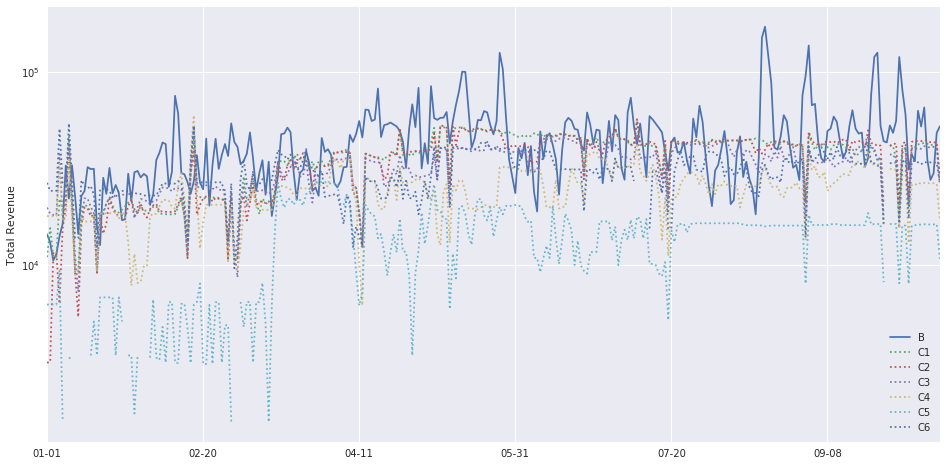

In [22]:
def time_series(seller, seller_groups):
    "Esta função constrói a série temporal 'data' x 'rendimento' das empresas."
    
    seller = seller_groups.get_group(seller)
    dates = seller['DATE'].unique()
    revenue_per_seller = {}
    for date in dates:
        revenue_per_seller[date] = seller[seller['DATE']==date]['REVENUE'].sum()
    revenue_per_seller = pd.Series(revenue_per_seller)
    revenue_per_seller = revenue_per_seller.sort_index()    
    return revenue_per_seller

seller_groups = new_data.groupby('SELLER')
revenue_per_seller = {}

for seller in sellers:
    revenue_per_seller[seller] = time_series(seller, seller_groups) 
    
# Cada série temporal é uma série em Pandas em que o índice é a data e o valor é o 
# rendimento total do dia.
revenue = pd.DataFrame(revenue_per_seller)

# Plots dos rendimentos por data para cada seller. Plotamos em escala logarítmica 
# para visualizar melhor.
revenue.plot(figsize=(16, 8), style=['-', ':', ':', ':', ':', ':', ':'])
sns.set_style("whitegrid")
plt.ylabel("Total Revenue")
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()

Como há muita flutuação nos valores, talvez seja mais interessante agrupá-los mensalmente. Dessa maneira esperamos poder ver mais facilmente os padrões. Com uma quantidade menor de datas, é possível fazer gráfico de barras, o que é mais claro neste caso.

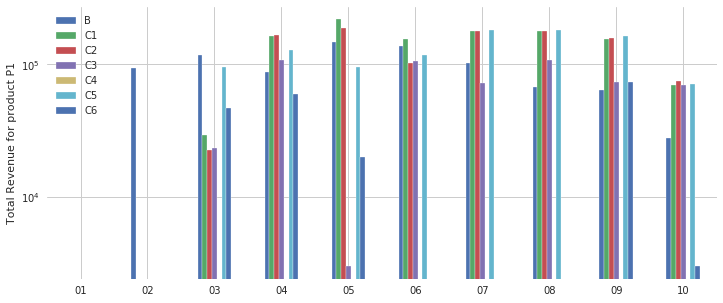

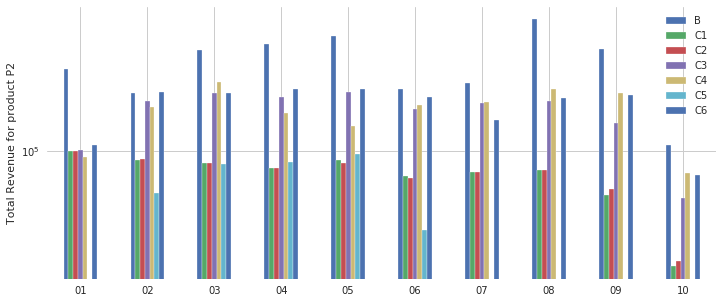

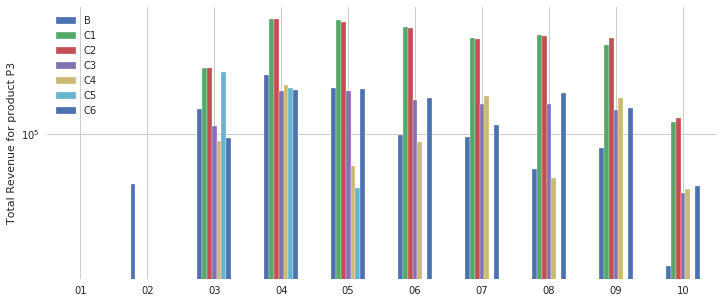

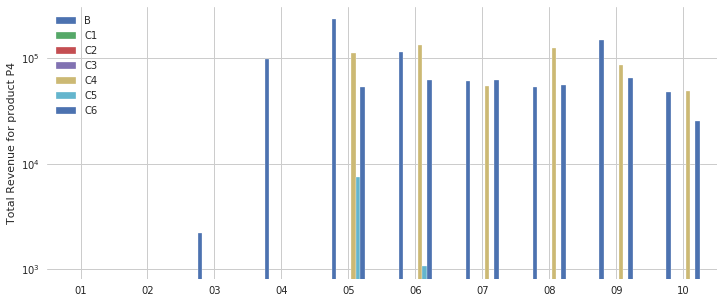

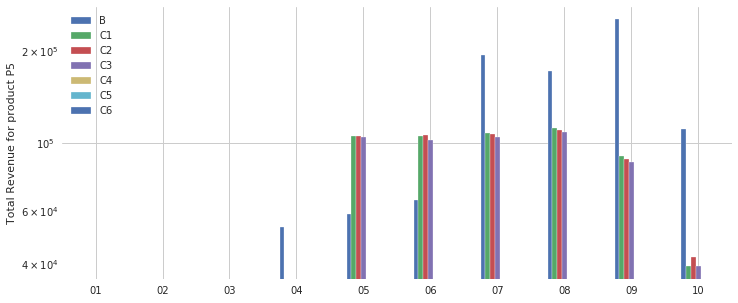

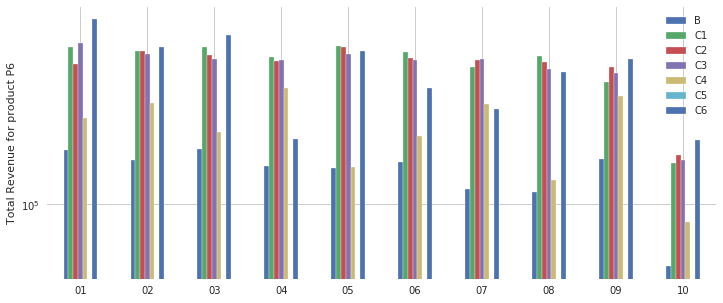

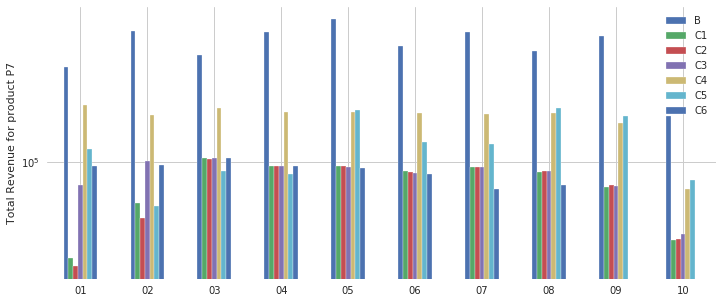

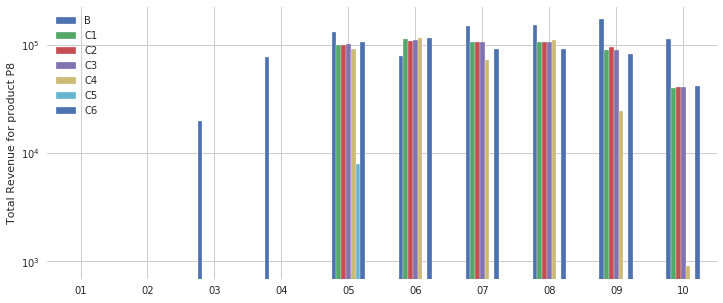

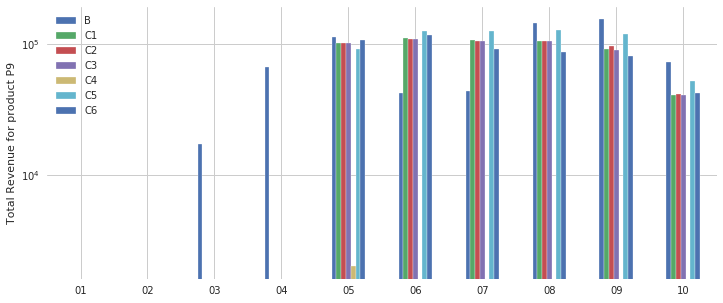

In [23]:
def time_series(p, seller, seller_groups):
    "Dado um produto p, Esta função constrói a série temporal 'data' x 'rendimento'."
    
    seller = seller_groups.get_group(seller)
    dates = seller['DATE'].unique()
    revenue_per_seller_and_product = {}
    for date in dates:
        tmp = seller[seller['DATE']==date][['PROD', 'REVENUE']]
        revenue_per_seller_and_product[date] = tmp[tmp['PROD']==p]['REVENUE'].sum()
    revenue_per_seller_and_product = pd.Series(revenue_per_seller_and_product)
    revenue_per_seller_and_product = revenue_per_seller_and_product.sort_index()    
    return revenue_per_seller_and_product

# Criamos um novo dataset com apenas os meses na coluna 'DATE'.
new_data_month = new_data.copy()
new_data_month['DATE'] = new_data_month['DATE'].str.split('-').str[0]

seller_groups = new_data_month.groupby('SELLER')
revenue_per_seller_and_product = {}

for p in products:
    for seller in sellers:
        revenue_per_seller_and_product[seller] = time_series(p, seller, seller_groups) 

    revenue = pd.DataFrame(revenue_per_seller_and_product)

    sns.set_style("whitegrid")
    revenue.plot(kind='bar', figsize=(12,5), rot=0)
    plt.ylabel("Total Revenue for product " + p)
    plt.yscale('log')
    if p in ['P1', 'P3', 'P4', 'P5', 'P8', 'P9']:
        plt.legend(loc='upper left')
    else:
        plt.legend(loc='upper right')
    plt.show()

# 3. Clusterização com K-means

Já temos uma ideia geral de como é o dataset e como as features se relacionam entre si. Agora devemos preparar o dataset para o treinamento. Iremos proceder da seguinte maneira:

 - As colunas serão 'PROD', 'DATE', 'QTY_ORDER', 'REVENUE_B', 'REVENUE_C' e 'MONTH'
 
 - Usaremos as datas no formato mês/dia. Podemos ter no máximo 9 linhas com a mesma data, pois cada instância de uma data será a média dos rendimentos de um produto específico vendido naquele dia.
 
 - O dataset será normalizado.

## 3.1. Junção dos datasets 

Agora que temos tudo mais organizado, queremos fazer um join nas linhas em que há coincidência de dia e produto. 

In [24]:
# Para simplificar o modelo, consideramos todos os competidores como sendo o mesmo.
# Também descartamos essa coluna no outro dataframe.
sales_updated = sales_updated.drop('SELLER', axis=1)
comp_updated = comp_updated.drop('SELLER', axis=1)

In [25]:
def day_avrg_dataframe(out_df, seller):
    """
    Organizamos as datas, de modo que cada data seja repetida no máximo 9 vezes, onde cada 
    ocorrência representa a média da venda de algum produto naquele dia. Ou seja, dada uma
    data específica e um produto específico, pegamos todas as linhas com esta data e produto
    e as colapsamos numa única linha, com REVENUE sendo as médias das REVENUEs das linhas.
    
    Parameters
    ----------
    out_df: dataframe
    seller: string
        Deve ser 'B' ou 'C' (a competição).
        
    Return
    ------
    df: dataframe
        Dataframe com o mesmo formato de out_df, mas com as datas organizadas segundo o 
        procedimento descrito.
    """
    
    dates = out_df['DATE'].unique()
    date_groups = out_df.groupby('DATE')
    d = []
    
    if seller != 'B':
        for date in dates:
            b = date_groups.get_group(date) 
            c = {}
            for p in b['PROD'].unique():
                c[p] = b[b['PROD']==p]['REVENUE'].mean()
                d.append([p, date, c[p]])
    else:
        for date in dates:
            b = date_groups.get_group(date) 
            c = {}
            for p in b['PROD'].unique():
                c[p] = b[b['PROD']==p][['QTY_ORDER', 'REVENUE']].mean()
                c[p] = list(c[p].values)
                d.append([p, date, float(int(c[p][0])), c[p][1]])
    if seller != 'B':               
        df = pd.DataFrame(d, columns=['PROD', 'DATE', 'REVENUE_'+seller]).sort_values('DATE')
    else:               
        df = pd.DataFrame(d, columns=['PROD', 'DATE', 'QTY_ORDER', 'REVENUE_'+seller]).sort_values('DATE')
    return df

new_sellers_datasets = {}
new_sellers_datasets['B'] = day_avrg_dataframe(sales_updated, 'B')
new_sellers_datasets['C'] = day_avrg_dataframe(comp_updated, 'C')

In [26]:
# Criamos o novo data set.
data1 = new_sellers_datasets['B']
data2 = new_sellers_datasets['C']
data = data1.merge(data2, how='inner', on=['PROD', 'DATE'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 0 to 1919
Data columns (total 5 columns):
PROD         1920 non-null object
DATE         1920 non-null object
QTY_ORDER    1920 non-null float64
REVENUE_B    1920 non-null float64
REVENUE_C    1920 non-null float64
dtypes: float64(3), object(2)
memory usage: 90.0+ KB


In [27]:
# O join não remove algumas informações relevantes de 'sales'. Em particular, queremos que 
# todo dia de 'sales' tenha alguma informação correspondente em 'comp'. Na ausência de 
# informação, iremos usar a própria  informação de 'sales' no lugar da informação da 
# competição.
products = sales_updated['PROD'].unique()
sales_sz = sales_updated.shape[0]
comp_groups = comp_updated.groupby('PROD')
new_rows = []
comp_p_dates = {}
for p in products:
    comp_p = comp_groups.get_group(p)
    comp_p_dates[p] = comp_p['DATE'].unique()

for i in range(sales_sz):
    row = sales_updated.iloc[i]
    d = row['DATE']
    p = row['PROD']
    if d not in comp_p_dates[p]:
        new_rows.append(row.values)

df = pd.DataFrame(new_rows, columns=['PROD', 'DATE', 'QTY_ORDER', 'REVENUE_B'])
df['REVENUE_C'] = df['REVENUE_B']

data = pd.concat([data, df], ignore_index=True, sort=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2697 entries, 0 to 2696
Data columns (total 5 columns):
PROD         2697 non-null object
DATE         2697 non-null object
QTY_ORDER    2697 non-null float64
REVENUE_B    2697 non-null float64
REVENUE_C    2697 non-null float64
dtypes: float64(3), object(2)
memory usage: 105.4+ KB


In [28]:
# Note o alto grau de correlação entre as features.
data.corr()

,QTY_ORDER,REVENUE_B,REVENUE_C
QTY_ORDER,1.000000,-0.042215,-0.207087
REVENUE_B,-0.042215,1.000000,0.939213
REVENUE_C,-0.207087,0.939213,1.000000


In [29]:
# Por fim, será interessante ter uma coluna com os meses apenas.
data['MONTH'] = data['DATE'].str.split('-').str[0].astype('int')
data.head()

,PROD,DATE,QTY_ORDER,REVENUE_B,REVENUE_C,MONTH
0,P6,01-01,1.0,1914.800,2166.783333,1
1,P7,01-01,31.0,1091.886,770.671818,1
2,P2,01-01,11.0,787.550,788.234000,1
3,P6,01-02,8.0,1914.800,2081.675385,1
4,P7,01-02,156.0,1259.416,771.834000,1


## 3.2. Normalização dos dados

Além de converter todas as features em números, necessitamos arrumar a escala destes números, pois a coluna 'REVENUE' possui valores muito mais altos que todas as outras colunas. Se não arrumarmos isso, a clusterização será enviesada em favor dos valores das colunas (pois o dataset será praticamente unidimensional), com as outras features tendo papel pouco relevante no processo. Existem diversas maneiras de normalizar as features. Aqui nós usaremos a *normalização pela média*, dada pela fórmula abaixo.

$$x_{new} = \frac{x - E[x]}{max(x) - min(x)}$$

$E[x]$ é a média dos valores da coluna de $x$, $max(x)$ é o máximo da coluna e $min(x)$ o mínimo da coluna. Faremos este procedimento para todas as colunas.

In [30]:
data_norm = data.copy()

s = data_norm['QTY_ORDER']
s = ( s - s.mean() )/( s.max() - s.min() )
data_norm['QTY_ORDER'] = s

for seller in ['B', 'C']:
    s = data_norm['REVENUE_'+seller]
    s = ( s - s.mean() )/( s.max() - s.min() )
    data_norm['REVENUE_'+seller] = s
    
data_norm.head()

,PROD,DATE,QTY_ORDER,REVENUE_B,REVENUE_C,MONTH
0,P6,01-01,-0.049867,0.352570,0.487341,1
1,P7,01-01,0.059224,0.021871,-0.073705,1
2,P2,01-01,-0.013503,-0.100431,-0.066647,1
3,P6,01-02,-0.024412,0.352570,0.453139,1
4,P7,01-02,0.513770,0.089195,-0.073238,1


## 3.3. Treinamento

In [31]:
# Para cada par (mês, produto) teremos um conjunto de clusters. Começamos agrupando os dados 
# desta maneira.
train_groups = {}
min_month = min(data_norm['MONTH'].unique())
max_month = max(data_norm['MONTH'].unique())
for m in range(min_month, max_month+1):
    for p in products:
        train_groups[str(m)+'_'+p] = data_norm[(data_norm['MONTH']==m) & (data_norm['PROD']==p)]


Month 1


<Figure size 432x288 with 0 Axes>

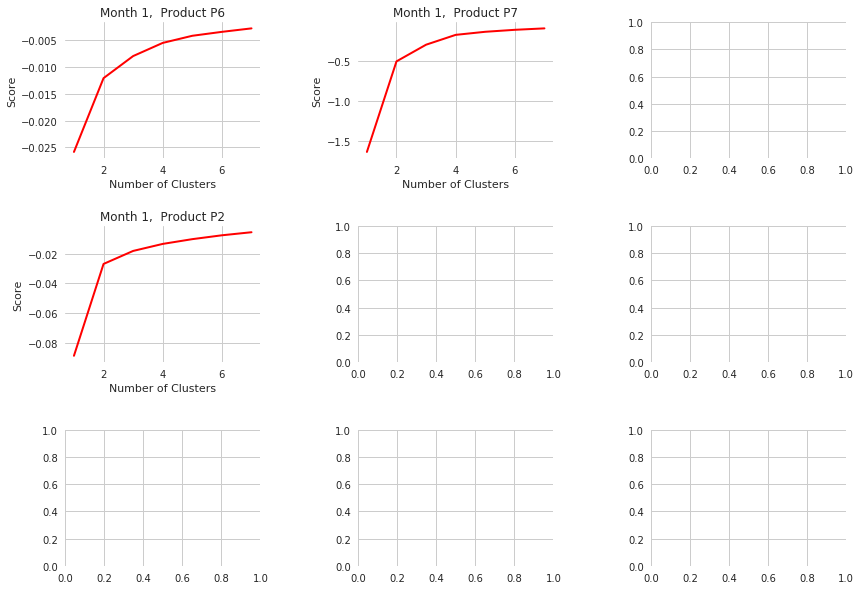


Month 2


<Figure size 432x288 with 0 Axes>

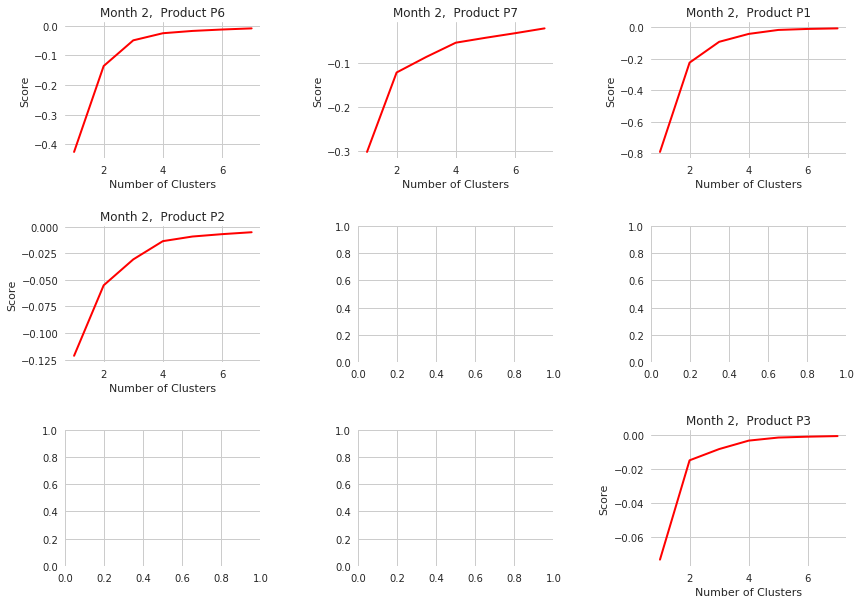


Month 3


<Figure size 432x288 with 0 Axes>

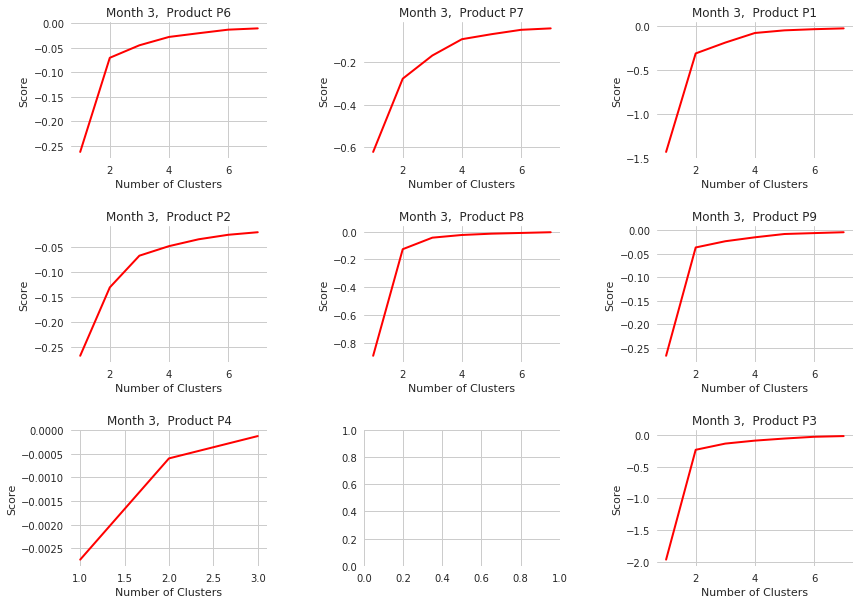


Month 4


<Figure size 432x288 with 0 Axes>

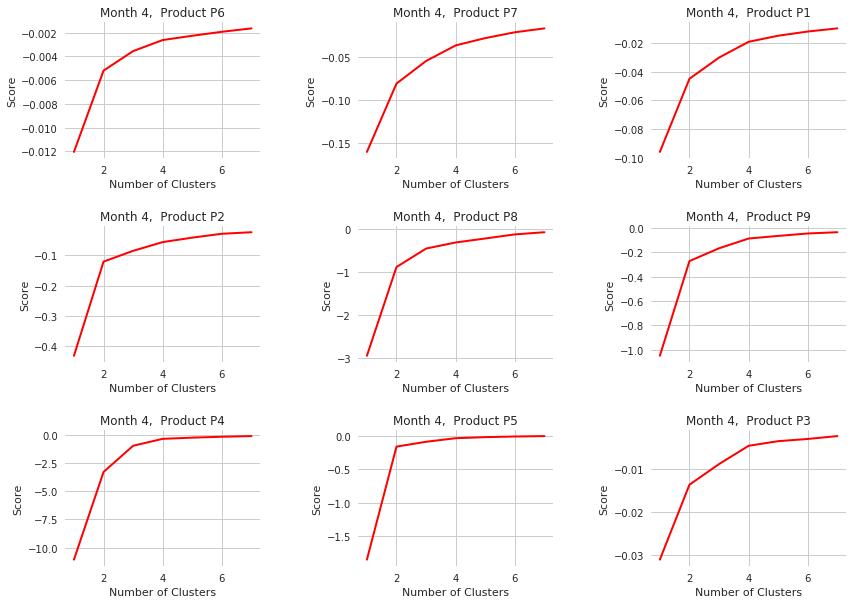


Month 5


<Figure size 432x288 with 0 Axes>

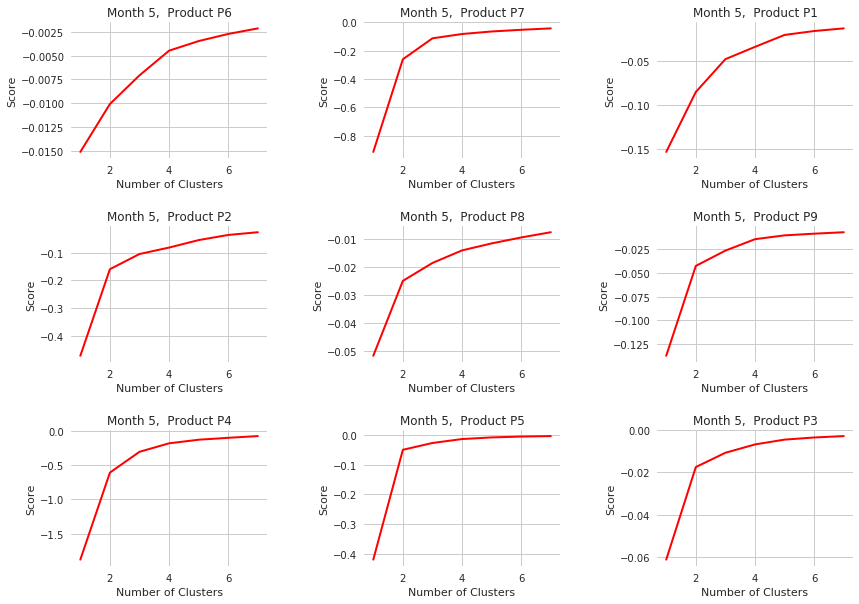


Month 6


<Figure size 432x288 with 0 Axes>

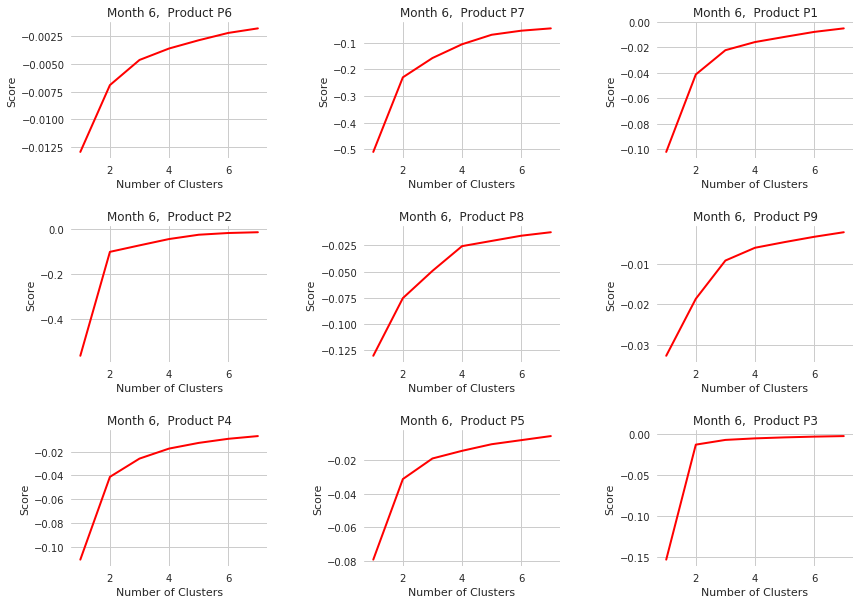


Month 7


<Figure size 432x288 with 0 Axes>

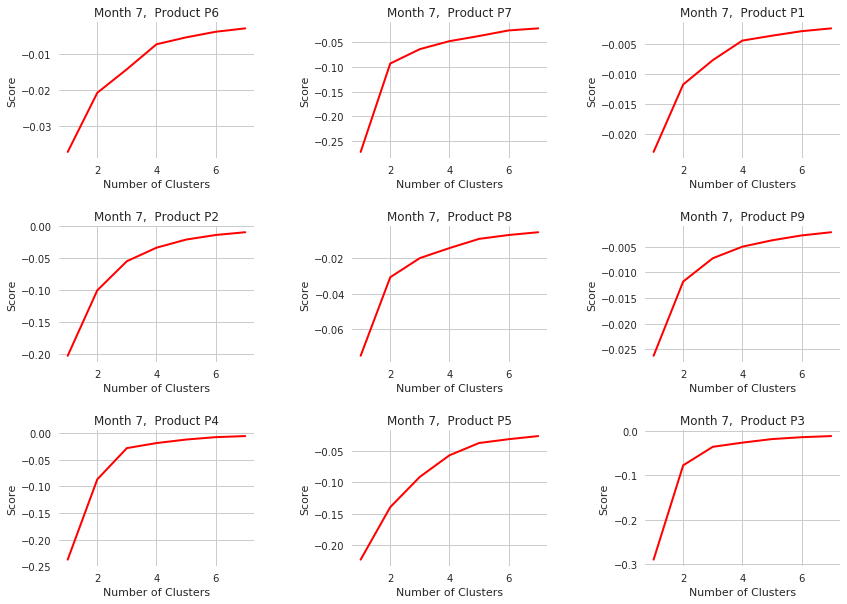


Month 8


<Figure size 432x288 with 0 Axes>

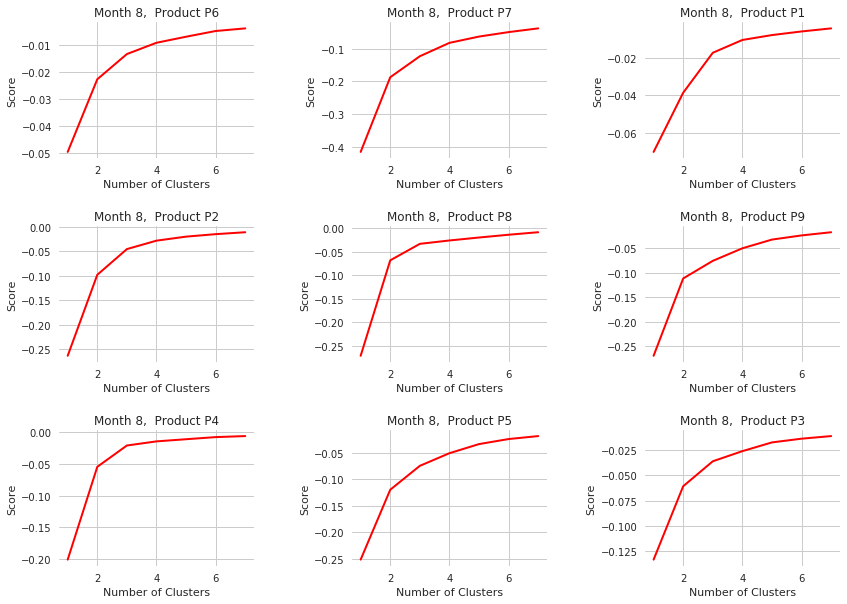


Month 9


<Figure size 432x288 with 0 Axes>

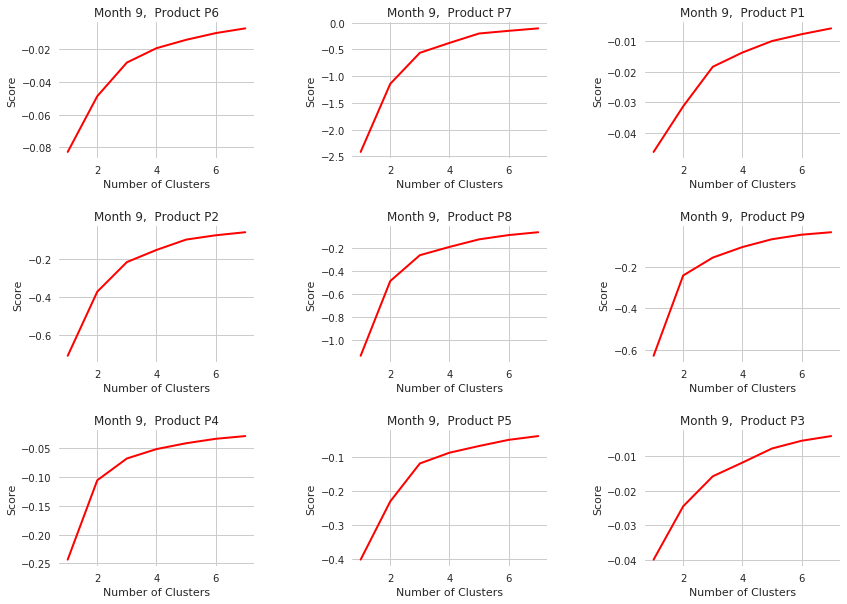


Month 10


<Figure size 432x288 with 0 Axes>

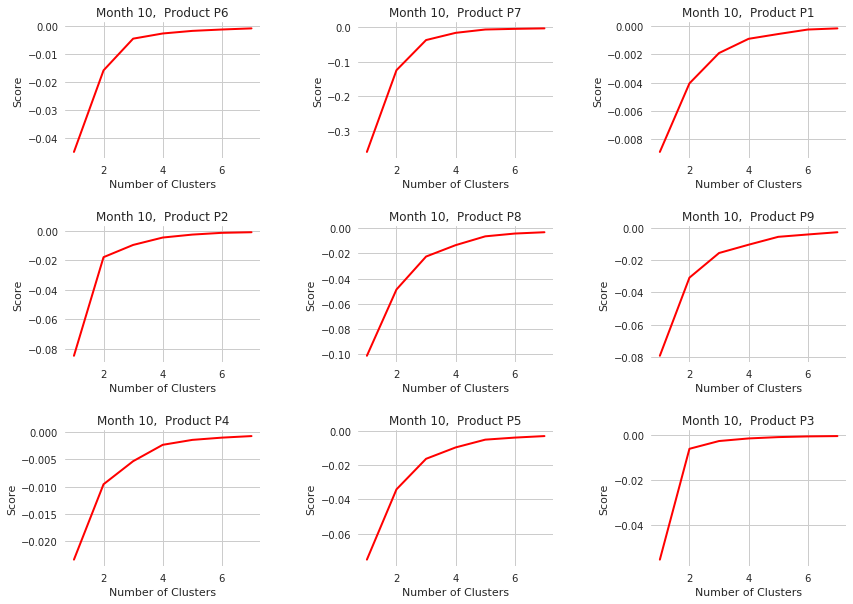

In [32]:
# Usamos o método 'elbow' para determinar o número de clusters. 
train_results = {}

def get_results(kmeans, scores):
    """
    Esta função coleta os resultados do método KMeans, de modo que o número de cluster
    deve satisfazer abs(score[i]) < 1e-3, caso contrário assumimos 8 clusters.
    """
    
    L = len(scores)
    for i in range(L):
        if abs(scores[i]) < 1e-3:
            return kmeans[i].cluster_centers_
    return kmeans[-1].cluster_centers_
        

k = 0
for m in range(min_month, max_month+1):
    i, j = 0, 0
    print()
    print('Month', m)
    plt.figure(k)
    k += 1
    fig, ax = plt.subplots(3, 3, figsize=(14, 10), facecolor='white')
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    for p in products:
        train_dataset = train_groups[str(m)+'_'+p]
        n_cluster = range(1, min(8, train_dataset.shape[0]))
        if train_dataset.size==0:
            pass
        else:
            # Sample é o dataframe relativo ao mês m e produto p.
            sample = train_dataset[train_dataset['PROD']==p][['QTY_ORDER', 'REVENUE_B', 'REVENUE_C']]
            # Aplicação do KMeans sobre sample.
            kmeans = [KMeans(n_clusters=i).fit(sample) for i in n_cluster]
            scores = [kmeans[i].score(sample) for i in range(len(kmeans))]
            # O número de clusters é o primeiro score satisfazendo abs(score[i]) < 1e-3.
            train_results[str(m)+'_'+p] = get_results(kmeans, scores)
            
            # Elbow curve plot
            ax[i,j].plot(n_cluster, scores, color='red', linewidth=2)
            ax[i,j].set(xlabel='Number of Clusters', ylabel='Score', title='Month ' + str(m) + ',  Product ' + p)
        j += 1
        if j==3:
            j = 0
            i += 1
    plt.show()

In [33]:
# Para fazer previsões, vamos reverter a normalização.
def denormalize(df, data):
    """
    Esta função cancela a normalização sobre df, onde a média, mínimo e máximo
    das colunas são obtidos do dataframe original data.
    
    Parameters
    ----------
    df, data: dataframes
        df um dataframe no espaço normalizado de data.
    
    Return
    ------
        Dataframe df sem anormalização.
    """
    
    s = data['QTY_ORDER']
    df['QTY_ORDER'] = ( s.max() - s.min() )*df['QTY_ORDER'] + s.mean()

    for seller in ['B', 'C']:
        s = data['REVENUE_'+seller]
        df['REVENUE_'+seller] = ( s.max() - s.min() )*df['REVENUE_'+seller] + s.mean()
    return pd.DataFrame(df, columns=['QTY_ORDER', 'REVENUE_B', 'REVENUE_C'])


# train_results_updated é a versão não-normalizada de train_results. Se trata de um dicionário 
# com keys no formato 'mês_produto', tais que train_results_updated['mês_produto'] é o 
# dataframe dos centróides (obtidos pelo KMeans) em relação ao par (mês, produto).
train_results_updated = {}
for m in range(min_month, max_month+1):
    for p in products:
        n_points = train_groups[str(m)+'_'+p].shape[0]
        if n_points != 0:
            df = pd.DataFrame(train_results[str(m)+'_'+p], columns=['QTY_ORDER', 'REVENUE_B', 'REVENUE_C']).copy()
            train_results_updated[str(m)+'_'+p] = denormalize(df, data) 
            train_results_updated[str(m)+'_'+p]['QTY_ORDER'] = train_results_updated[str(m)+'_'+p]['QTY_ORDER'].astype('int').copy()

É interessante obsevar quantos clusters há para cada par (mês, produto). Também é de interesse saber quantos pontos foram usados para o treinamento em cada caso. Vamos ver isso abaixo. 

In [34]:
df = []

for m in range(min_month, max_month+1):
    for p in products:
        n_points = train_groups[str(m)+'_'+p].shape[0]
        if n_points != 0:
            n_centroids = train_results[str(m)+'_'+p].shape[0]
            df.append([m, p, int(n_points), int(n_centroids)])

df = pd.DataFrame(df, columns=['MONTH', 'PROD', 'NUM POINTS', 'NUM CLUSTERS'])
df.head()

,MONTH,PROD,NUM POINTS,NUM CLUSTERS
0,1,P6,31,7
1,1,P7,30,7
2,1,P2,31,7
3,2,P6,27,7
4,2,P7,28,7


## 3.4. Predição

In [35]:
def prediction(month, product, revenue_b, revenue_c, train_results_updated):
    """
    Dado o mês, o produto e os dois preços, verificamos qual o centróide mais perto da 
    coordenadas dos preços. Este centróide está relacionado a uma certa quantidade que 
    foi obtida durante o treinamento. Esta será a quantidade que usaremos para a predição.  
    
    Parameters
    ----------
    month: int
    product: string
    revenue_b, revenue_c: float
    train_results_updated: dict
    
    Return
    ------
    int com a quantidade prevista em relação aos inputs dados.
    """
    
    dataset = train_results_updated[str(month)+'_'+product]
    point1 = np.array([revenue_b, revenue_c])
    dataset_sz = dataset.shape[0]
    best_distance = np.inf
        
    # Busca pelo melhor centróide.
    for i in range(dataset_sz):
        point2 = dataset.iloc[i][['REVENUE_B', 'REVENUE_C']].values
        distance = np.linalg.norm(point1 - point2)
        if distance < best_distance:
            best_distance = distance
            idx = i
            
    return dataset.iloc[idx]['QTY_ORDER']

Apenas para efeito de ilustração, vamos olhar o caso do mês 4 e produto P3. Lembre que cada amostra é um vetor tridimensional com as informações ['QTY_ORDER', 'REVENUE_B', 'REVENUE_C']. Iremos fazer um scatter plot no plano, onde o eixo $x$ é 'REVENUE_B' e o eixo $y$ é 'REVENUE_C'. A quantidade será monitorada através da cor dos pontos, que foram obtidos durante o treinamento.

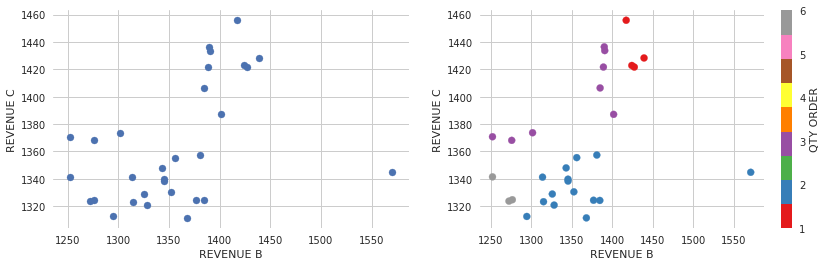

In [36]:
# Declaração de variáveis iniciais.
i = 0
month = 4
product = 'P3'

# Tomamos um pedaço do dataframe, no caso do mês 4 e o produto P4.
data_example = data[(data['PROD']==product) & (data['MONTH']==month)]

# Predição das quantidades que devem ser vendidas neste pedaço do dataframe.
predictions = []
for x in range(data_example.shape[0]):
    revenue_b, revenue_c = data_example.iloc[i]['REVENUE_B'], data_example.iloc[i]['REVENUE_C']
    qty_order = prediction(month, product, revenue_b, revenue_c, train_results_updated)
    predictions.append(qty_order)
    i += 1

# Plot dos dados originais sem clusterização.
fig, ax = plt.subplots(1, 2, figsize=[14, 4])
ax[0].scatter(data_example['REVENUE_B'], data_example['REVENUE_C'])
ax[0].set(xlabel='REVENUE B', ylabel='REVENUE C')

# Plot com clusterização das previsões.
im = ax[1].scatter(data_example['REVENUE_B'], data_example['REVENUE_C'], c=predictions, cmap='Set1')
ax[1].set(xlabel='REVENUE B', ylabel='REVENUE C')
plt.colorbar(im, ax=ax[1], label='QTY ORDER')
plt.show()

## 3.5. Acurácia do modelo

Agora que vimos que o algoritmo está separando bem os clusters, vamos como está a acurácia dele. Para isso, faremos previsões para todos os dados do dataset original, após o tratamento (mais precisamente, estamos nos referindo ao dataframe *data*). 

Sejam $y^{(1)}, \ldots, y^{(n)}$ aos targets originais do dataset, onde $y^{(i)}$ é o elemento da linha $i$ e coluna 'QTY_ORDER', e sejam $\tilde{y}^{(1)}, \ldots, \tilde{y}^{(n)}$ as previsões dadas pelo nosso modelo. Uma maneira de se medir a acurácia do nosso modelo é usando a métrica RMLSE (Root Mean Squared Logarithmic Error). Esta métrica geralmente é usada quando não queremos penalizar grandes diferenças nos valores previstos e os reais quando os valores previstos e verdadeiros são grandes. Ela é definida por

$$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log(1 + \tilde{y}^{(i)}) - \log(1 + y^{(i)}) \right)^2} .$$

A grosso modo, esta métrica nos dá um fator de proporcionalidade entre o valor previsto e o real. Quanto maior for o valor, pior é a previsão, e quanto mais perto de zero, melhor é a previsão. 

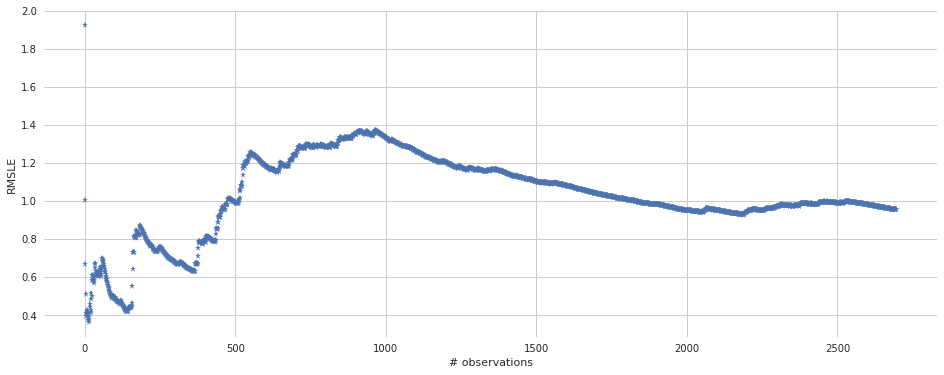

In [37]:
# Criamos um dicionário para guardar as predisões por mês e produto.
predictions = {}
errors = []
cum_errors = []

for m in range(min_month, max_month+1):
    for p in products:
        data_example = data[(data['PROD']==p) & (data['MONTH']==m)]
        if (data_example.size!=0) and (str(m)+'_'+p in train_results_updated.keys()):
            i = 0
            for x in range(data_example.shape[0]):
                revenue_b, revenue_c = data_example.iloc[i]['REVENUE_B'], data_example.iloc[i]['REVENUE_C']
                predicted = prediction(m, p, revenue_b, revenue_c, train_results_updated)
                actual = data_example.iloc[i]['QTY_ORDER']
                errors.append(np.log(1+predicted) - np.log(actual))
                errors_tmp = np.array(errors)
                cum_errors.append(np.mean(errors_tmp**2)) 
                predictions[str(m)+'_'+p] = [actual, predicted]
                i += 1

# Plot da evolução do RMSLE. Podemos ver que o modelo tende a melhorar conforme mais dados são 
# inseridos nele.
fig = plt.figure(figsize=[16, 6])
plt.plot(cum_errors, '*')
plt.xlabel('# observations')
plt.ylabel('RMSLE')
plt.show()

In [38]:
# Para finalizar, usamos o dicionário para criar um dataframe comparando as predições com os 
# valores reais. Este dataframe é salvo no disco.
predictions = pd.DataFrame(predictions.values(), index=predictions.keys(), columns=['ACTUAL', 'PREDICTED'])
predictions.to_csv('predictions.csv')
predictions.head()

,ACTUAL,PREDICTED
1_P6,2.0,2.0
1_P7,23.0,66.0
1_P2,8.0,11.0
2_P6,2.0,2.0
2_P7,57.0,135.0


# 4. Trabalhando com SQL

Todo o trabalho até agora foi feito em Pandas, mas pode ocorrer de ser necessário começar com SQL. Iremos mostrar como proceder assim usando sqlite. Esta parte é apenas para ilustrar uma maneira de se proceder caso os dados originais não viessem como csv, mas sim num banco de dados.

In [39]:
import sqlite3
import pandas as pd

In [40]:
# Começamos abrindo ambos os dataframes.
sales = pd.read_csv("sales.csv")
comp = pd.read_csv("comp_prices.csv")

In [41]:
# Criamos conexões e importamos os csv's para SQL, aí poderemos tratá-los como databases para 
# usar o sqlite3.
conn_sales = sqlite3.connect('sales.db')
sales.to_sql('sales', con=conn_sales, if_exists='replace', index=False)
conn_comp = sqlite3.connect('comp.db')
comp.to_sql('comp', con=conn_comp, if_exists='replace', index=False)

In [42]:
# Criamos as classes 'cursor_sales' e 'cursor_comp' para executar as queries.
cursor_sales = conn_sales.cursor()
cursor_comp = conn_comp.cursor()

In [43]:
# Contagem do número de linhas.
cursor_sales.execute('SELECT COUNT(PROD_ID) FROM sales')
cursor_comp.execute('SELECT COUNT(PROD_ID) FROM comp')
rows_sales = cursor_sales.fetchall()
rows_comp = cursor_comp.fetchall()

In [44]:
# Remoção dos outliers e das colunas desnecessárias.
cursor_sales.execute("SELECT COUNT(PROD_ID) FROM sales WHERE REVENUE < 2980;")
cursor_comp.execute("SELECT COUNT(PROD_ID) FROM comp WHERE COMPETITOR_PRICE < 8100;")
new_rows_sales = cursor_sales.fetchall()
new_rows_comp = cursor_comp.fetchall()

# Observamos que a porcentagem de dados removidos é igual ao procedimento anterior.
print(100-100*new_rows_sales[0][0]/rows_sales[0][0], '%')
print(100-100*new_rows_comp[0][0]/rows_comp[0][0], '%')

0.506136585671527 %
0.15165422835933384 %


A partir daqui já reduzimos bastante o tamanho das tabelas (duas colunas e mais algumas linhas foram 
removidas). Os pŕoximo seguintes passos seriam arrumar o nome de algumas colunas e passar a função 
fix_qty_order. Como esta função é mais complicada, retornamos ao uso de dataframes. A partir desse ponto podemos repetir todo o procedimento anterior.


In [45]:
cursor_sales.execute("DELETE FROM sales WHERE REVENUE > 2980;")
cursor_comp.execute("DELETE FROM comp WHERE COMPETITOR_PRICE > 8100;")
conn_sales.commit()
conn_comp.commit()

sales_updated = pd.read_sql("SELECT * FROM sales;", conn_sales)
comp_updated = pd.read_sql_query("SELECT PROD_ID, DATE_EXTRACTION, COMPETITOR_PRICE FROM comp;", conn_comp)

In [46]:
conn_sales.close()
conn_comp.close()